# AI 201 Mini Project
## Coffee Match: Leveraging Machine Learning for Coffee Bean Recommendations Using Taste Profiles
### Recommender Model Implementation

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [45]:
%pip install scikit-learn numpy pandas optuna tqdm plotly

Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
import plotly
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

## Load the cleaned dataset

In [47]:
# Define the same column names from the EDA notebook
feature_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 
                'balance', 'uniformity', 'clean_cup', 'sweetness']
label_cols = ['country_of_origin', 'variety', 'processing_method']

In [48]:
# Read the cleaned dataset
loaded_df = pd.read_csv('datasets/preprocessed_coffee_data.csv')

# Split into X and y using these column names
X = loaded_df[feature_cols].to_numpy()
y = loaded_df[label_cols].to_numpy()

## Split the dataset into training and test sets

In [49]:
# Add stratification for better distribution of labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

## Recommender Models
- Truncated SVD
- Non-negative Matrix Factorization

In [50]:
def train_svd(X_train, n_components=5):
    """
    Train SVD model with specified parameters
    
    Parameters:
    -----------
    X_train_scaled : array-like
        Scaled training data
    n_components : int, default=5
        Number of components to keep
        
    Returns:
    --------
    tuple
        (trained SVD model, transformed training data)
    """
    svd = TruncatedSVD(
        n_components=n_components,
        random_state=0,
        algorithm='randomized'
    )
    X_train_svd = svd.fit_transform(X_train)
    
    # Add explained variance ratio information
    # print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")
    
    return svd, X_train_svd

In [51]:
def train_nmf(X_train, n_components=5):
    """
    Train NMF model with optimized parameters
    
    Parameters:
    -----------
    X_train_scaled : array-like
        Scaled training data
    n_components : int, default=5
        Number of components to keep
        
    Returns:
    --------
    tuple
        (trained NMF model, transformed training data)
    """    
    nmf = NMF(
        n_components=n_components,
        init='nndsvd',
        max_iter=500,
        random_state=0,
        solver='cd',
        tol=1e-4
    )
    
    X_train_nmf = nmf.fit_transform(X_train)
    
    # Add reconstruction error information
    # print(f"Reconstruction error: {nmf.reconstruction_err_:.4f}")
    
    return nmf, X_train_nmf

In [52]:
def get_recommendations(model, X_train_scaled, query_vector, k=5, is_nmf=False, minmax_scaler=None):
    """
    Get recommendations for a query coffee
    
    Parameters:
    -----------
    model : sklearn model
        Trained SVD or NMF model
    X_train_scaled : array-like
        Scaled training data
    query_vector : array-like
        The coffee we want recommendations for
    k : int, default=5
        Number of recommendations to return
    is_nmf : bool, default=False
        Whether we're using NMF model
    minmax_scaler : sklearn.preprocessing.MinMaxScaler, default=None
        Scaler for NMF input transformation
        
    Returns:
    --------
    tuple
        (indices of similar items, similarity scores)
    """
    # Transform query
    if is_nmf:
        if minmax_scaler is None:
            raise ValueError("minmax_scaler must be provided for NMF recommendations")
        query_shifted = minmax_scaler.transform(query_vector.reshape(1, -1))
        train_shifted = minmax_scaler.transform(X_train_scaled)
        query_transformed = model.transform(query_shifted)
        train_transformed = model.transform(train_shifted)
    else:
        query_transformed = model.transform(query_vector.reshape(1, -1))
        train_transformed = model.transform(X_train_scaled)
    
    # Calculate similarities
    similarities = cosine_similarity(query_transformed, train_transformed)[0]
    
    # Get top k similar coffees
    similar_indices = similarities.argsort()[::-1][:k]
    similar_scores = similarities[similar_indices]
    
    return similar_indices, similar_scores

In [53]:
# # Test the recommendations
# # Get recommendations for the first coffee in test set
# test_idx = 0
# print("Getting recommendations for test coffee index:", test_idx)
# print("\nOriginal coffee features:")
# print("Features:", dict(zip(feature_cols, X_test[test_idx])))
# print("\nLabels:", dict(zip(label_cols, y_test[test_idx])))

In [54]:
# # Get SVD recommendations
# svd_indices, svd_scores = get_recommendations(svd, X_train_scaled, X_test_scaled[test_idx])
# print("\nSVD Recommendations:")
# for idx, score in zip(svd_indices, svd_scores):
#     print(f"\nSimilarity Score: {score:.4f}")
#     print("Features:", dict(zip(feature_cols, X_train[idx])))
#     print("Labels:", dict(zip(label_cols, y_train[idx])))

In [55]:
# # Get NMF recommendations
# nmf_indices, nmf_scores = get_recommendations(nmf, X_train_scaled, X_test_scaled[test_idx], is_nmf=True)
# print("\nNMF Recommendations:")
# for idx, score in zip(nmf_indices, nmf_scores):
#     print(f"\nSimilarity Score: {score:.4f}")
#     print("Features:", dict(zip(feature_cols, X_train[idx])))
#     print("Labels:", dict(zip(label_cols, y_train[idx])))

## Evaluate the recommender models

In [56]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_top_k_predictions(model, X_train_scaled, X_test_scaled, y_train, k=5, is_nmf=False, minmax_scaler=None):
    """
    Get top-k predictions for each test sample
    
    Parameters:
    -----------
    model : sklearn model
        Trained SVD or NMF model
    X_train_scaled : array-like
        Scaled training features
    X_test_scaled : array-like
        Scaled test features
    y_train : array-like
        Training labels
    k : int, default=5
        Number of recommendations to return
    is_nmf : bool, default=False
        Whether using NMF model
    minmax_scaler : sklearn.preprocessing.MinMaxScaler, default=None
        Scaler for NMF input transformation
        
    Returns:
    --------
    list of tuples
        Each tuple contains (pred_countries, pred_varieties, pred_processes)
    """
    predictions = []
    
    # Transform data based on model type
    if is_nmf:
        if minmax_scaler is None:
            raise ValueError("minmax_scaler must be provided for NMF")
        X_test_scaled = X_test_scaled - X_test_scaled.min(axis=0)

    train_transformed = model.transform(X_train_scaled)
    test_transformed = model.transform(X_test_scaled)
    
    # Calculate cosine similarities
    similarities = cosine_similarity(test_transformed, train_transformed)
    
    # Generate predictions
    for i in range(len(X_test_scaled)):
        similar_indices = similarities[i].argsort()[::-1][:k]  # Top-k indices
        pred_countries = y_train[similar_indices, 0]  # country_of_origin
        pred_varieties = y_train[similar_indices, 1]  # variety
        pred_processes = y_train[similar_indices, 2]  # processing_method
        
        predictions.append((pred_countries, pred_varieties, pred_processes))
    
    return predictions

def compute_map(y_true, predictions, weights, k=5):
    """
    Compute Mean Average Precision (mAP) for multi-label recommendation tasks.
    """
    ap_scores = []

    for i in range(len(y_true)):
        true_country, true_variety, true_process = y_true[i]
        pred_countries, pred_varieties, pred_processes = predictions[i]

        # Track correct predictions
        correct_country = 0
        correct_variety = 0
        correct_process = 0

        # Precision at each step
        precisions = []

        for j in range(k):
            if pred_countries[j] == true_country:
                correct_country += 1
            if pred_varieties[j] == true_variety:
                correct_variety += 1
            if pred_processes[j] == true_process:
                correct_process += 1

            # Compute weighted precision at current step
            precision = (
                weights['country'] * correct_country / (j + 1) +
                weights['variety'] * correct_variety / (j + 1) +
                weights['process'] * correct_process / (j + 1)
            )
            precisions.append(precision)

        # Compute AP (Average Precision) for current sample
        if precisions:  # At least one correct prediction
            ap = sum(precisions) / len(precisions)  # Mean of precisions at all recall levels
        else:
            ap = 0  # No correct predictions

        ap_scores.append(ap)

    return np.mean(ap_scores)


def compute_precision_at_k(y_true, predictions, weights, k=5):
    """
    Calculate weighted Precision@k for multi-label predictions.
    """
    total_precision = 0
    
    for i in range(len(y_true)):
        true_country, true_variety, true_process = y_true[i]
        pred_countries, pred_varieties, pred_processes = predictions[i]

        correct_countries = sum(1 for c in pred_countries[:k] if c == true_country)
        correct_varieties = sum(1 for v in pred_varieties[:k] if v == true_variety)
        correct_processes = sum(1 for p in pred_processes[:k] if p == true_process)

        precision_country = correct_countries / k
        precision_variety = correct_varieties / k
        precision_process = correct_processes / k

        weighted_precision = (
            weights['country'] * precision_country +
            weights['variety'] * precision_variety +
            weights['process'] * precision_process
        )

        total_precision += weighted_precision

    return total_precision / len(y_true)

def evaluate_recommendations(model, X_train_scaled, X_test_scaled, y_train, y_test, k=5, is_nmf=False, min_max_scaler=None):
    """
    Evaluate recommender system using various metrics
    """
    # Define weights
    n_countries = len(np.unique(y_train[:, 0]))
    n_varieties = len(np.unique(y_train[:, 1]))
    n_processes = len(np.unique(y_train[:, 2]))
    
    # print(f"n_countries = {n_countries}")
    # print(f"n_varieties = {n_varieties}")
    # print(f"n_processes = {n_processes}")
    
    weights = {
        'country': 1 / n_countries,
        'variety': 1 / n_varieties,
        'process': 1 / n_processes
    }
    total = sum(weights.values())
    weights = {k: v / total for k, v in weights.items()}
    
    # Get predictions
    predictions = get_top_k_predictions(
        model, X_train_scaled, X_test_scaled, y_train,
        k=k, is_nmf=is_nmf, minmax_scaler=min_max_scaler
    )
    
    # Compute metrics
    precision_at_k = compute_precision_at_k(y_test, predictions, weights, k)
    map_score = compute_map(y_test, predictions, weights, k)
    
    return {
        f"precision@{k}": precision_at_k,
        "map": map_score
    }

In [57]:
def plot_metrics_comparison(svd_metrics, nmf_metrics):
    """
    Plot comparison of model metrics
    
    Parameters:
    -----------
    svd_metrics : dict
        Dictionary of SVD model metrics
    nmf_metrics : dict
        Dictionary of NMF model metrics
    """
    metrics = list(svd_metrics.keys())
    svd_values = list(svd_metrics.values())
    nmf_values = list(nmf_metrics.values())
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, svd_values, width, label='SVD', color='skyblue')
    rects2 = ax.bar(x + width/2, nmf_values, width, label='NMF', color='lightcoral')
    
    # Add value labels on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', rotation=0)
    
    autolabel(rects1)
    autolabel(rects2)
    
    ax.set_ylabel('Score')
    ax.set_title('Comparison of SVD and NMF Models')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()    

In [58]:
# Scale the features
std_scaler = StandardScaler()
X_train_svd_scaled = std_scaler.fit_transform(X_train)
X_test_svd_scaled = std_scaler.transform(X_test)

# Scale the features (important for SVD and NMF)
min_max_scaler = MinMaxScaler()
X_train_nmf_scaled = min_max_scaler.fit_transform(X_train)
X_test_nmf_scaled = min_max_scaler.transform(X_test)

/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


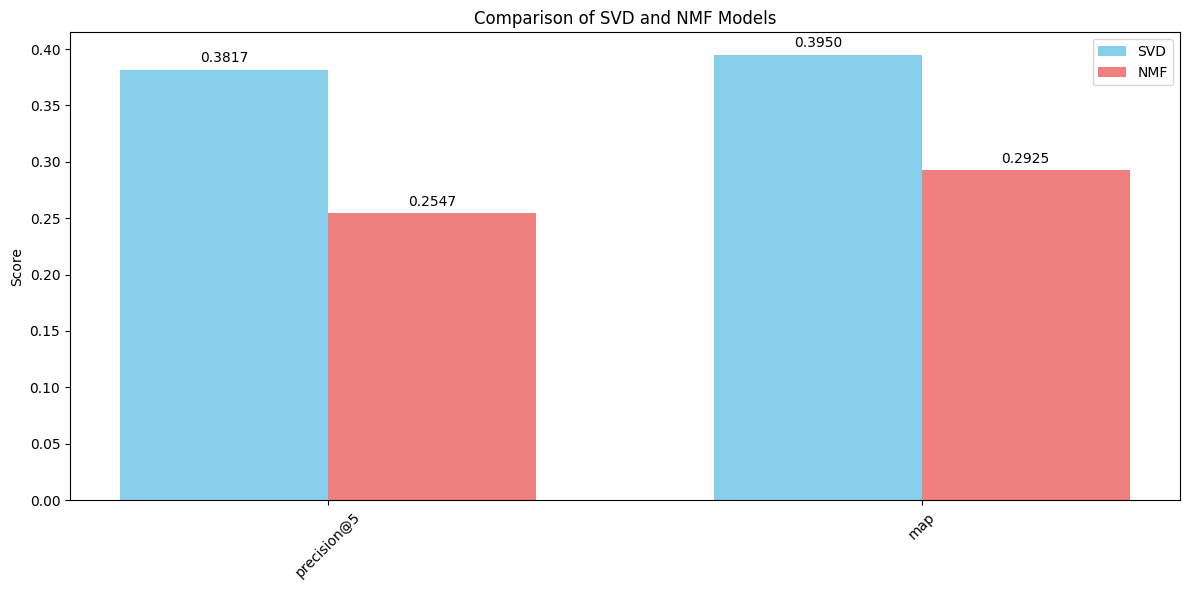

In [59]:
# Train models
svd, X_train_svd = train_svd(X_train_svd_scaled)
nmf, X_train_nmf = train_nmf(X_train_nmf_scaled)

# Evaluate models
svd_metrics = evaluate_recommendations(
    svd, X_train_svd_scaled, X_test_svd_scaled, y_train, y_test
)
nmf_metrics = evaluate_recommendations(
    nmf, X_train_nmf_scaled, X_test_nmf_scaled, y_train, y_test,
    is_nmf=True, min_max_scaler=min_max_scaler
)

# Plot comparison
plot_metrics_comparison(svd_metrics, nmf_metrics)

## Perform hyperparameter optimization

In [60]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

def objective_nmf(trial, X_train_scaled, y_train):
    """
    Objective function for NMF hyperparameter optimization
    """
    # Get minimum dimension
    min_dim = min(X_train_scaled.shape)
    
    # First select solver since it affects beta_loss options
    solver = trial.suggest_categorical('solver', ['cd', 'mu'])
    
    # Define beta_loss based on solver
    if solver == 'cd':
        # CD solver only works with 'frobenius'
        beta_loss = 'frobenius'
    else:
        # MU solver works with all beta_loss options
        beta_loss = trial.suggest_categorical('beta_loss', ['frobenius', 'kullback-leibler'])
        # Removed 'itakura-saito' due to convergence issues with zero values
    
    # Define other hyperparameters
    n_components = trial.suggest_int('n_components', 2, min(min_dim, 15))
    init = trial.suggest_categorical('init', ['nndsvd', 'nndsvdar', 'random'])
    tol = trial.suggest_float('tol', 1e-5, 1e-3, log=True)
    
    try:
        # Ensure non-negative input
        minmax_scaler = MinMaxScaler()
        X_train_shifted = minmax_scaler.fit_transform(X_train_scaled)
        
        # Add small epsilon to prevent zeros
        X_train_shifted = X_train_shifted + 1e-6
        
        # Create and train model
        nmf = NMF(
            n_components=n_components,
            init=init,
            solver=solver,
            beta_loss=beta_loss,
            tol=tol,
            max_iter=2000,  # Increased to 2000 as requested
            random_state=0
        )
        
        # Transform data
        X_transformed = nmf.fit_transform(X_train_shifted)
        
        # Calculate performance metrics using cross-validation
        k = 5  # Number of recommendations
        cv_scores = []
        
        # Perform cross-validation manually to use our custom evaluation metric
        from sklearn.model_selection import KFold
        kf = KFold(n_splits=3, shuffle=True, random_state=0)
        
        for train_idx, val_idx in kf.split(X_transformed):
            X_train_fold, X_val_fold = X_transformed[train_idx], X_transformed[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate similarities
            similarities = cosine_similarity(X_val_fold, X_train_fold)
            
            # Calculate metrics for this fold
            fold_metrics = []
            for i in range(len(X_val_fold)):
                top_k_indices = similarities[i].argsort()[-k:][::-1]
                
                # Get actual and predicted labels
                true_labels = y_val_fold[i]
                pred_labels = y_train_fold[top_k_indices]
                
                # Calculate weighted precision@k
                correct_predictions = np.sum(pred_labels == true_labels.reshape(1, -1), axis=0)
                weighted_precision = np.mean(correct_predictions / k)
                
                fold_metrics.append(weighted_precision)
            
            cv_scores.append(np.mean(fold_metrics))
        
        return np.mean(cv_scores)
    
    except Exception as e:
        # Return a poor score if the model fails
        print(f"Trial failed with error: {str(e)}")
        return float('-inf')

def objective_svd(trial, X_train_scaled, y_train):
    """
    Objective function for SVD hyperparameter optimization
    """
    # Get minimum dimension
    min_dim = min(X_train_scaled.shape)
    
    # Define hyperparameters to optimize
    algorithm = trial.suggest_categorical('algorithm', ['randomized', 'arpack'])
    
    # Adjust n_components based on algorithm
    if algorithm == 'arpack':
        # For arpack: 0 < n_components < min(X.shape)
        n_components = trial.suggest_int('n_components', 2, min(min_dim - 1, 15))
    else:
        # For randomized: can use any value up to min(X.shape)
        n_components = trial.suggest_int('n_components', 2, min(min_dim, 15))
    
    tol = trial.suggest_float('tol', 1e-5, 1e-3, log=True)
    
    try:
        # Create and train model
        svd_params = {
            'n_components': n_components,
            'algorithm': algorithm,
            'tol': tol,
            'random_state': 0,
            'n_iter': 2000  # Increased to 2000 as requested
        }
            
        svd = TruncatedSVD(**svd_params)
        
        # Transform data
        X_transformed = svd.fit_transform(X_train_scaled)
        
        # Calculate performance metrics using cross-validation
        k = 5  # Number of recommendations
        cv_scores = []
        
        # Perform cross-validation manually to use our custom evaluation metric
        kf = KFold(n_splits=3, shuffle=True, random_state=0)
        
        for train_idx, val_idx in kf.split(X_transformed):
            X_train_fold, X_val_fold = X_transformed[train_idx], X_transformed[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Calculate similarities
            similarities = cosine_similarity(X_val_fold, X_train_fold)
            
            # Calculate metrics for this fold
            fold_metrics = []
            for i in range(len(X_val_fold)):
                top_k_indices = similarities[i].argsort()[-k:][::-1]
                
                # Get actual and predicted labels
                true_labels = y_val_fold[i]
                pred_labels = y_train_fold[top_k_indices]
                
                # Calculate weighted precision@k
                correct_predictions = np.sum(pred_labels == true_labels.reshape(1, -1), axis=0)
                weighted_precision = np.mean(correct_predictions / k)
                
                fold_metrics.append(weighted_precision)
            
            cv_scores.append(np.mean(fold_metrics))
        
        return np.mean(cv_scores)
    
    except Exception as e:
        # Return a poor score if the model fails
        print(f"Trial failed with error: {str(e)}")
        return float('-inf')

def optimize_svd(X_train_scaled, y_train, n_trials=50):
    """
    Optimize both SVD model using Optuna
    """
    # Create studies for both models
    svd_study = optuna.create_study(direction='maximize')
    
    # Optimize SVD
    print("Optimizing SVD...")
    svd_study.optimize(
        lambda trial: objective_svd(trial, X_train_scaled, y_train),
        n_trials=n_trials
    )
    
    # Get best parameters
    best_svd_params = svd_study.best_params
    
    # Create optimized SVD model
    svd_params = {
        'n_components': best_svd_params['n_components'],
        'algorithm': best_svd_params['algorithm'],
        'tol': best_svd_params['tol'],
        'random_state': 0
    }
    if best_svd_params['algorithm'] == 'randomized':
        svd_params['n_iter'] = 1000
    best_svd = TruncatedSVD(**svd_params)
    
    return best_svd, svd_study

def optimize_nmf(X_train_scaled, y_train, n_trials=50):
    """
    Optimize NMF model using Optuna
    """
    # Create study
    nmf_study = optuna.create_study(direction='maximize')
    
    # Optimize NMF
    print("\nOptimizing NMF...")
    nmf_study.optimize(
        lambda trial: objective_nmf(trial, X_train_scaled, y_train),
        n_trials=n_trials
    )
    
    # Get best parameters
    best_nmf_params = nmf_study.best_params
        
    # Create optimized NMF model
    best_nmf = NMF(
        **best_nmf_params,
        random_state=0
    )
    
    return best_nmf, nmf_study

[I 2024-11-24 23:16:09,277] A new study created in memory with name: no-name-09c3debe-7cf0-4756-a382-9ebfbe49c38d
[I 2024-11-24 23:16:09,319] Trial 0 finished with value: 0.25953517987901936 and parameters: {'algorithm': 'arpack', 'n_components': 3, 'tol': 4.3667918482260585e-05}. Best is trial 0 with value: 0.25953517987901936.


Optimizing SVD...


[I 2024-11-24 23:16:09,508] Trial 1 finished with value: 0.2787010506208214 and parameters: {'algorithm': 'randomized', 'n_components': 7, 'tol': 0.0008683626881287638}. Best is trial 1 with value: 0.2787010506208214.
[I 2024-11-24 23:16:09,547] Trial 2 finished with value: 0.27379815345431396 and parameters: {'algorithm': 'arpack', 'n_components': 6, 'tol': 0.0001998362359969246}. Best is trial 1 with value: 0.2787010506208214.
[I 2024-11-24 23:16:09,722] Trial 3 finished with value: 0.26602992677491244 and parameters: {'algorithm': 'randomized', 'n_components': 4, 'tol': 9.021800845891732e-05}. Best is trial 1 with value: 0.2787010506208214.
[I 2024-11-24 23:16:09,906] Trial 4 finished with value: 0.2787010506208214 and parameters: {'algorithm': 'randomized', 'n_components': 7, 'tol': 1.3229537019370599e-05}. Best is trial 1 with value: 0.2787010506208214.
[I 2024-11-24 23:16:10,095] Trial 5 finished with value: 0.25717924227952876 and parameters: {'algorithm': 'randomized', 'n_compo


Optimizing NMF...


[I 2024-11-24 23:16:17,231] Trial 1 finished with value: 0.26660299267749127 and parameters: {'solver': 'mu', 'beta_loss': 'kullback-leibler', 'n_components': 4, 'init': 'nndsvdar', 'tol': 0.0008228538238354747}. Best is trial 0 with value: 0.26914995224450816.
/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
[I 2024-11-24 23:16:17,397] Trial 2 finished with value: 0.2789557465775231 and parameters: {'solver': 'cd', 'n_components': 9, 'init': 'nndsvd', 'tol': 0.0006333221052189216}. Best is trial 2 with value: 0.2789557465775231.
/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1610: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads 

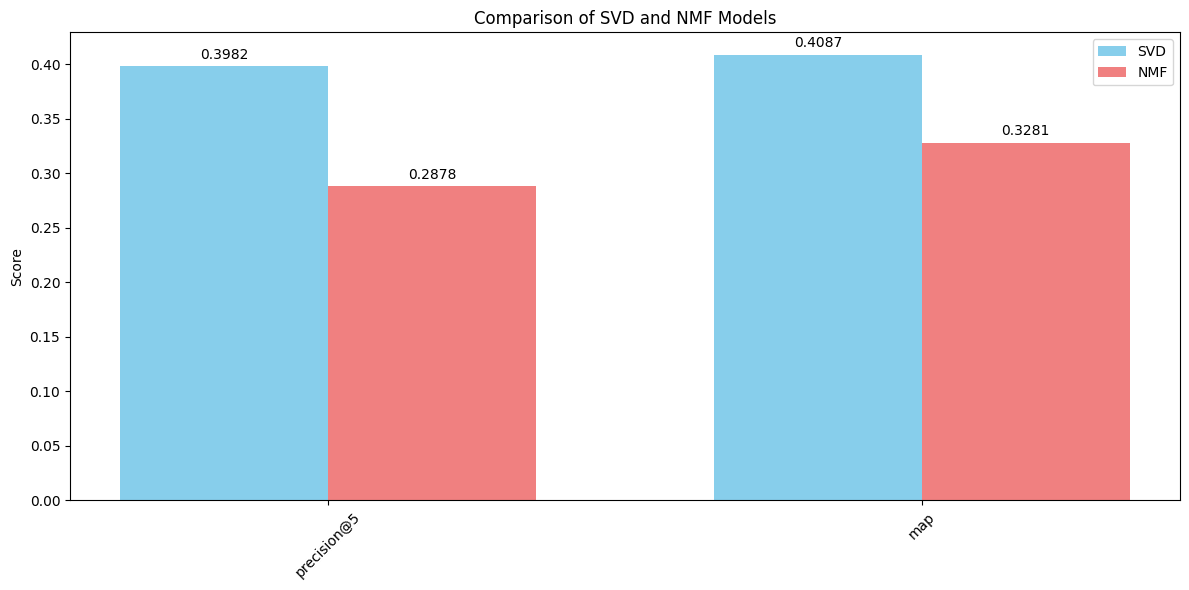

In [61]:
# Optimize models
best_svd, svd_study = optimize_svd(X_train_svd_scaled, y_train, n_trials=50)
best_nmf, nmf_study = optimize_nmf(X_train_nmf_scaled, y_train, n_trials=50)

# Train models with optimal parameters
X_train_svd = best_svd.fit_transform(X_train_svd_scaled)
X_train_nmf = best_nmf.fit_transform(X_train_nmf_scaled)

# Evaluate optimized models
svd_metrics = evaluate_recommendations(
    best_svd, X_train_svd_scaled, X_test_svd_scaled, y_train, y_test
)
nmf_metrics = evaluate_recommendations(
    best_nmf, X_train_nmf_scaled, X_test_nmf_scaled, y_train, y_test, 
    is_nmf=True, min_max_scaler=min_max_scaler
)

# Plot comparison
plot_metrics_comparison(svd_metrics, nmf_metrics)

## Train the recommender system on resampled data

In [62]:
smote_df = pd.read_csv('datasets/preprocessed_coffee_data_resampled.csv')

# Split into X and y using these column names
X_smote = smote_df[feature_cols].to_numpy()
y_smote = smote_df[label_cols].to_numpy()

In [63]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=0
)

In [64]:
# Scale the features
std_scaler = StandardScaler()
X_train_svd_scaled = std_scaler.fit_transform(X_train_smote)
X_test_svd_scaled = std_scaler.transform(X_test_smote)

# Scale the features (important for SVD and NMF)
min_max_scaler = MinMaxScaler()
X_train_nmf_scaled = min_max_scaler.fit_transform(X_train_smote)
X_test_nmf_scaled = min_max_scaler.transform(X_test_smote)

/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


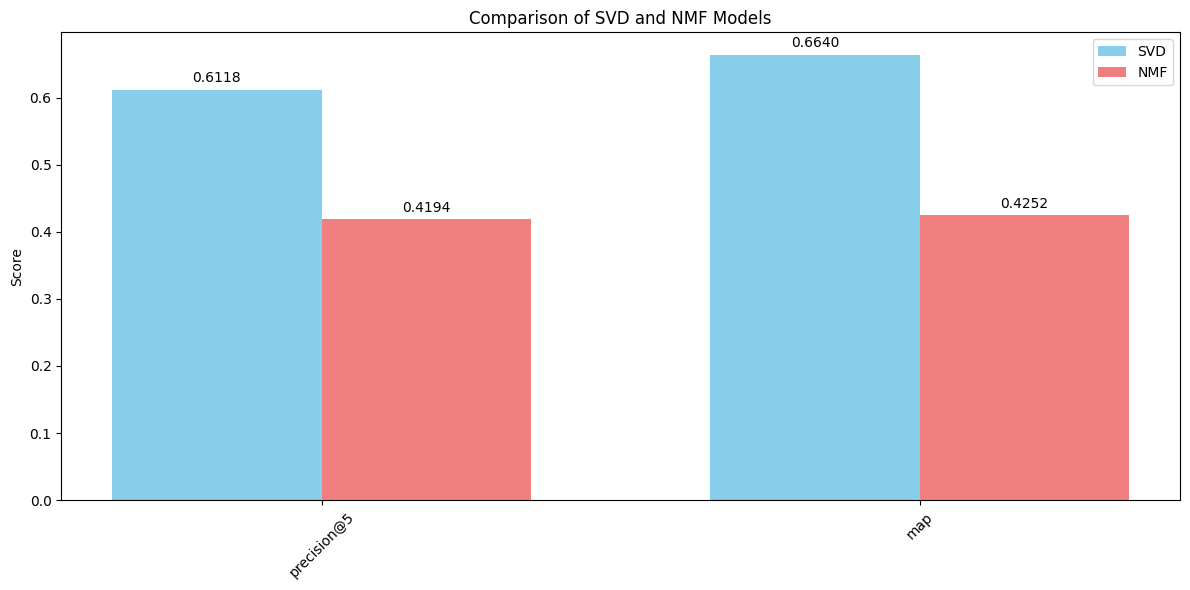

In [65]:
# Train models
svd, X_train_svd = train_svd(X_train_svd_scaled)
nmf, X_train_nmf = train_nmf(X_train_nmf_scaled)

# Evaluate models
svd_metrics = evaluate_recommendations(
    svd, X_train_svd_scaled, X_test_svd_scaled, y_train_smote, y_test_smote
)
nmf_metrics = evaluate_recommendations(
    nmf, X_train_nmf_scaled, X_test_nmf_scaled, y_train_smote, y_test_smote,
    is_nmf=True, min_max_scaler=min_max_scaler
)

# Plot comparison
plot_metrics_comparison(svd_metrics, nmf_metrics)

[I 2024-11-24 23:16:24,071] A new study created in memory with name: no-name-8c3fd374-fdcb-498c-9c9f-40db1c49adf0


Optimizing SVD...


[I 2024-11-24 23:16:24,794] Trial 0 finished with value: 0.7106656566710156 and parameters: {'algorithm': 'randomized', 'n_components': 9, 'tol': 1.3858064258903247e-05}. Best is trial 0 with value: 0.7106656566710156.
[I 2024-11-24 23:16:25,141] Trial 1 finished with value: 0.5888584902236943 and parameters: {'algorithm': 'arpack', 'n_components': 5, 'tol': 1.6624473163639307e-05}. Best is trial 0 with value: 0.7106656566710156.
[I 2024-11-24 23:16:25,486] Trial 2 finished with value: 0.6137674414716449 and parameters: {'algorithm': 'arpack', 'n_components': 6, 'tol': 1.5236831113577671e-05}. Best is trial 0 with value: 0.7106656566710156.
[I 2024-11-24 23:16:25,832] Trial 3 finished with value: 0.4981667894962732 and parameters: {'algorithm': 'arpack', 'n_components': 3, 'tol': 0.00031489120956952545}. Best is trial 0 with value: 0.7106656566710156.
[I 2024-11-24 23:16:26,495] Trial 4 finished with value: 0.5888584902236943 and parameters: {'algorithm': 'randomized', 'n_components': 


Optimizing NMF...


/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
[I 2024-11-24 23:16:55,357] Trial 0 finished with value: 0.6138525007366927 and parameters: {'solver': 'cd', 'n_components': 7, 'init': 'nndsvdar', 'tol': 0.00032709404004941425}. Best is trial 0 with value: 0.6138525007366927.
/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
[I 2024-11-24 23:16:55,971] Trial 1 finished with value: 0.6728937952334514 and parameters: {'solver': 'mu', 'beta_loss': 'frobenius', 'n_components': 9, 'init': 'nndsvdar', 'tol': 0.00011084604910805108}. Best is trial 1 with value: 0.6728937952334514.
/Users

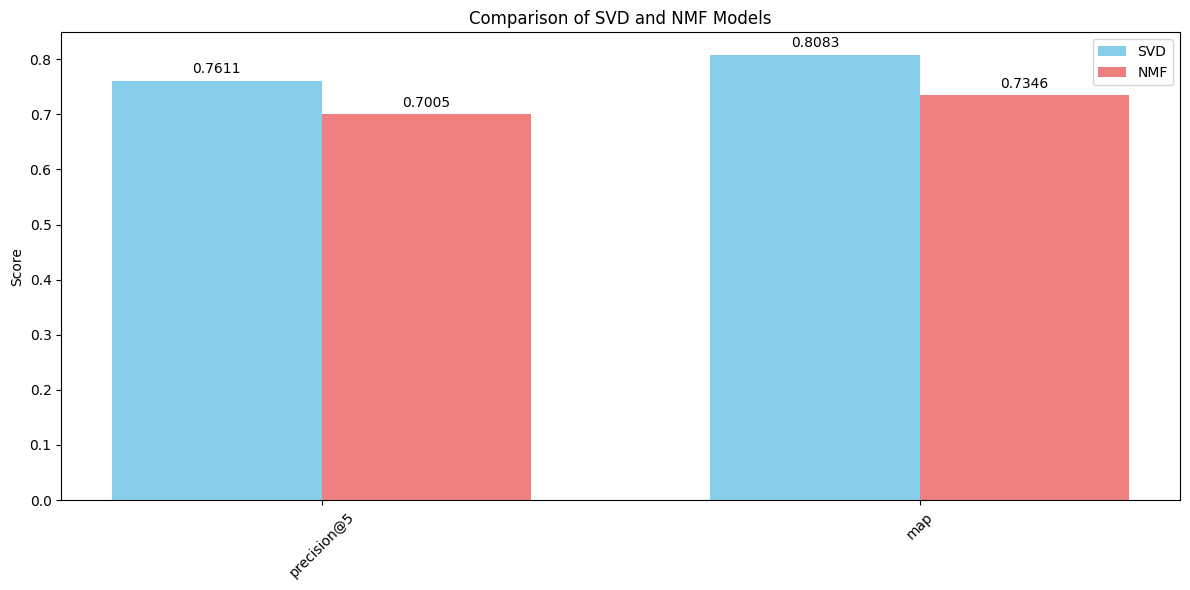

In [66]:
# Optimize models
best_svd, svd_study = optimize_svd(X_train_svd_scaled, y_train_smote, n_trials=50)
best_nmf, nmf_study = optimize_nmf(X_train_nmf_scaled, y_train_smote, n_trials=50)

# Train models with optimal parameters
X_train_svd = best_svd.fit_transform(X_train_svd_scaled)
X_train_nmf = best_nmf.fit_transform(X_train_nmf_scaled)

# Evaluate optimized models
svd_metrics = evaluate_recommendations(
    best_svd, X_train_svd_scaled, X_test_svd_scaled, y_train_smote, y_test_smote
)
nmf_metrics = evaluate_recommendations(
    best_nmf, X_train_nmf_scaled, X_test_nmf_scaled, y_train_smote, y_test_smote, 
    is_nmf=True, min_max_scaler=min_max_scaler
)

# Plot comparison
plot_metrics_comparison(svd_metrics, nmf_metrics)